## Генерация полифонической музыки с кондишнингом

Импортируем torch и numpy:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random

Сделаем также пользовательский импорт

In [2]:
from decode_patterns import data_conversion

In [3]:
data_height = 64
drum_width = 14
melody_width = 36
data_width = drum_width + melody_width
data_size = data_height*data_width
patterns_file = "decode_patterns/patterns.pairs.tsv"

Загружаем датасет

In [4]:
# import dataset
drum, bass = data_conversion.make_lstm_dataset_conditioning(height=data_height,
                                                            limit=1000,
                                                            patterns_file=patterns_file,
                                                            mono=False)
# print(drum[0])
# drum, bass = np.array(drum), np.array(bass)
# print(drum[0])

# define shuffling of dataset
def shuffle(A, B, p=0.8):
    # take 80% to training, other to testing
    AB = list(zip(A, B))
    L = len(AB)
    pivot = int(p*L)
    random.shuffle(AB)
    yield [p[0] for p in AB[:pivot]]
    yield [p[1] for p in AB[:pivot]]
    yield [p[0] for p in AB[pivot:]]
    yield [p[1] for p in AB[pivot:]]
    
    
# we can select here a validation set
drum, bass, drum_validation, bass_validation = shuffle(drum, bass)
    
# and we can shuffle train and test set like this:
# drum_train, bass_train, drum_test, bass_test = shuffle(drum, bass)

In [5]:
bass[16]

NumpyImage(image=array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), tempo=96, instrument=33, denominator=2, min_note=31)

Модель определим в самом простом варианте, который только можно себе представить -- как в примере с конечным автоматом

In [6]:
# Encoder = LSTM
# Decoder = FCNN
class DrumNBass_LSTM_to_FCNN(nn.Module):
    def __init__(self, bass_height, bass_width):
        super(DrumNBass_LSTM_to_FCNN, self).__init__()
        # save data parameters
        self.bass_height = bass_height
        self.bass_width = bass_width
        self.bass_size = bass_height*bass_width
        self.condition_size = 2 # размер подмешиваемого conditioning
        self.embedding_size = 2 # размер латентного пространства
        # one input neuron, one output neuron, one layer in LSTM block
        self.input_size = 14
        self.lstm_hidden_size = 4
        self.lstm_layer_count = 1
        self.lstm = nn.LSTM(self.input_size, self.lstm_hidden_size, self.lstm_layer_count)
        self.lstm_preembed_layer = nn.Linear(self.lstm_hidden_size, 1)
        self.lstm_embed_layer_mean = nn.Linear(self.bass_height, self.embedding_size)
        self.lstm_embed_layer_logvar = nn.Linear(self.bass_height, self.embedding_size)
        
        self.decoder_layer1 = nn.Linear(self.embedding_size + self.condition_size, 48)
        self.decoder_layer2 = nn.Linear(48 + self.condition_size, 512)
        self.decoder_layer3 = nn.Linear(512, self.bass_size)
        self.sigm = nn.Sigmoid()
        
    def encoder(self, input):
        # пусть в input у нас приходит вектор размерности (32, 128, 14)
        # где имеется 32 примера (минибатч) по 128 отсчётов, 14 значений в каждом (барабанная партия)
        # Тогда его надо транспонировать в размерность (128, 32, 14)
        input = input.transpose(0,1)
        output, _ = self.lstm(input)
        output = self.sigm(self.lstm_preembed_layer(output))
        # избавляемся от лишней размерности (embedding_size=1), чтобы получить вектор из lstm
        # размером с высоту изображения
        output = output.squeeze().transpose(0,1)
        mean = self.sigm(self.lstm_embed_layer_mean(output))
        logvar = self.sigm(self.lstm_embed_layer_logvar(output))
        return mean, logvar
    
    # reference:
    # https://github.com/pytorch/examples/blob/master/vae/main.py
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    # end reference
    
    def decoder(self, input, cond):
        output = torch.cat((input, cond), axis=1) # добавляем conditioning
        output = self.sigm(self.decoder_layer1(output))
        output = torch.cat((output, cond), axis=1) # добавляем ещё conditioning
        output = self.sigm(self.decoder_layer2(output))
        output = self.sigm(self.decoder_layer3(output))
        return output
    
    @staticmethod
    def get_images(input):
        return torch.tensor(list(map(lambda p: p.image, input)), dtype=torch.float)
    
    def forward(self, input):
        images = self.get_images(input)
        mean, logvar = self.encoder(images)
        # генерируем случайную точку в латентном пространстве
        result = self.reparameterize(mean, logvar)
        # добавляем conditioning
        conditionings = torch.tensor(list(map(lambda p: [p.tempo, p.instrument], input)), dtype=torch.float)
        conditionings = conditionings
        result = self.decoder(result, conditionings)
        return result.view((-1, self.bass_height, self.bass_width)), mean, logvar

In [7]:
# часть обучения
dnb_lstm = DrumNBass_LSTM_to_FCNN(data_height, melody_width)

# criterion = nn.MSELoss() # -- с этим всё работает (точнее, работало)
# criterion = nn.NLLLoss() # -- этот товарищ требует, чтобы LSTM выдавал классы,
# criterion = nn.CrossEntropyLoss() # и этот тоже
# (числа от 0 до C-1), но как всё-таки его заставить это делать?...

# оценим также и разнообразие мелодии по её.. дисперсии?)
# def melody_variety(melody):
#     return 1/(1 + (melody.sum(axis=2) > 1).int())

# на самом деле, попробуем функцию потерь взять из VAE

# Reference: https://github.com/pytorch/examples/blob/master/vae/main.py
# Reconstruction + KL divergence losses summed over all elements and batch
def reconstruction_KL_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

optimizer = optim.Adam(dnb_lstm.parameters(), lr=0.001)
# optimizer = optim.SGD(dnb_lstm.parameters(), lr=0.001, momentum=0.9)

Посмотрим, как модель форвардится на один пример

In [8]:
dnb_lstm.forward([drum_validation[16], drum_validation[14], drum_validation[43]])[0].size()

torch.Size([3, 64, 36])

In [9]:
bass_validation[16].image.shape

(64, 36)

Найденные баги и их решения:

https://stackoverflow.com/questions/56741087/how-to-fix-runtimeerror-expected-object-of-scalar-type-float-but-got-scalar-typ

https://stackoverflow.com/questions/49206550/pytorch-error-multi-target-not-supported-in-crossentropyloss/49209628

https://stackoverflow.com/questions/56243672/expected-target-size-50-88-got-torch-size50-288-88

In [10]:
epoch_count = 500
batch_size = 32
shuffle_every_epoch = True
    
if shuffle_every_epoch:
    print(f"shuffle_every_epoch is on")
else:
    print(f"shuffle_every_epoch is off")
    # shuffle train and test set:
    drum_train, bass_train, drum_test, bass_test = shuffle(drum, bass)
        
for epoch in range(epoch_count):  # loop over the dataset multiple times
    print(f"Epoch #{epoch}")
    if shuffle_every_epoch:
        # shuffle train and test set:
        drum_train, bass_train, drum_test, bass_test = shuffle(drum, bass)
        
    examples_count = len(drum_train)
    examples_id = 0
    
    running_loss = 0.0
    runnint_count = 0
    batch_id = 0
    while examples_id < examples_count:
        batch_drum_train = drum_train[examples_id:examples_id + batch_size]
        batch_bass_train = bass_train[examples_id:examples_id + batch_size]
        
        batch_bass_train_raw = torch.tensor(list(map(lambda p: p.image, batch_bass_train)), dtype=torch.float)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        bass_outputs, mu, stddev = dnb_lstm(batch_drum_train)
        # bass_outputs = bass_outputs.squeeze()
        
        # loss = criterion(bass_outputs, batch_bass_train_raw)
        loss = 0
        for i in range(batch_size):
            loss += reconstruction_KL_loss_function(bass_outputs[i], batch_bass_train_raw[i], mu[i], stddev[i])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        runnint_count += 1
        period = 5
        if batch_id % period == 0 or examples_id + batch_size >= examples_count:
            print('[%d, %5d] train loss: %.7f' %
                  (epoch + 1, batch_id + 1, running_loss / runnint_count))
            running_loss = 0.0
            runnint_count = 1
            
        # update batch info
        examples_id += batch_size
        batch_id += 1
        
    # here we can insert measure error on test set

#should check accuracy on validation set
print('Finished Training')

shuffle_every_epoch is on
Epoch #0
[1,     1] train loss: 52125.9023438
[1,     6] train loss: 25525.0371094
[1,    11] train loss: 9759.0524902
[1,    16] train loss: 4895.7207845
[1,    20] train loss: 3481.0973145
Epoch #1
[2,     1] train loss: 3720.9016113
[2,     6] train loss: 3285.1103516
[2,    11] train loss: 2925.7307536
[2,    16] train loss: 2904.8113607
[2,    20] train loss: 3110.7432129
Epoch #2
[3,     1] train loss: 3266.3041992
[3,     6] train loss: 2943.2654215
[3,    11] train loss: 2891.2506104
[3,    16] train loss: 2909.2460124
[3,    20] train loss: 2739.1002930
Epoch #3
[4,     1] train loss: 4076.9580078
[4,     6] train loss: 2869.7117106
[4,    11] train loss: 2744.4845785
[4,    16] train loss: 2760.8789469
[4,    20] train loss: 2772.6697266
Epoch #4
[5,     1] train loss: 3496.8679199
[5,     6] train loss: 2704.4653727
[5,    11] train loss: 2880.0553385
[5,    16] train loss: 2942.2054850
[5,    20] train loss: 2522.5009277
Epoch #5
[6,     1] train l

[43,     1] train loss: 3153.0776367
[43,     6] train loss: 2511.5885824
[43,    11] train loss: 2444.9548747
[43,    16] train loss: 2567.3107096
[43,    20] train loss: 2472.3983887
Epoch #43
[44,     1] train loss: 3339.8098145
[44,     6] train loss: 2532.5107422
[44,    11] train loss: 2355.7728678
[44,    16] train loss: 2546.6046549
[44,    20] train loss: 2375.9749512
Epoch #44
[45,     1] train loss: 3140.5610352
[45,     6] train loss: 2420.6847331
[45,    11] train loss: 2481.9594320
[45,    16] train loss: 2507.0131836
[45,    20] train loss: 2477.0117676
Epoch #45
[46,     1] train loss: 2850.5766602
[46,     6] train loss: 2389.5799561
[46,    11] train loss: 2596.9346517
[46,    16] train loss: 2439.7569987
[46,    20] train loss: 2528.6986816
Epoch #46
[47,     1] train loss: 3197.3476562
[47,     6] train loss: 2394.8559570
[47,    11] train loss: 2499.7471924
[47,    16] train loss: 2491.4066976
[47,    20] train loss: 2396.3103516
Epoch #47
[48,     1] train loss: 3

KeyboardInterrupt: 

### Этап эксплуатации нейросети
Посмотрим на результаты, что выдаёт нейросеть на выходе...

In [11]:
with torch.no_grad():
    bass_outputs = dnb_lstm(drum_train)
result = bass_outputs[0].squeeze().int()
# result

Однако, более интересно посмотреть на то, что получилось в латентном пространстве... Неплохо было бы визуализировать точки в латентном пространстве

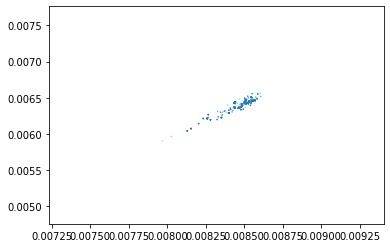

In [13]:
with torch.no_grad():
    latent_train = dnb_lstm.encoder(dnb_lstm.get_images(drum_train))
    
mu, dev = latent_train

# libraries
import matplotlib.pyplot as plt
import numpy as np
 
# create data
x = mu[:,0]
y = mu[:,1]
z = dev
 
# use the scatter function
plt.scatter(x, y, s=z*20, alpha=0.5)
plt.show()


Попробуем сохранить результаты работы сети. На anaconda нет mido, поэтому сохраняем результаты работы просто в массивчик npy... Однако, как альтернатива, его можно поставить чере pip в conda:
https://github.com/mido/mido/issues/198

In [14]:
import mido
from decode_patterns.data_conversion import build_track, DrumMelodyPair, NumpyImage, Converter


converter = Converter((data_height, data_width))

batch_drum = drum_train + drum_test + drum_validation
batch_drum = drum_validation
batch_bass = bass_train + bass_test + bass_validation
batch_bass = drum_validation
with torch.no_grad():
    bass_outputs = dnb_lstm(batch_drum)[0]
    bass_outputs = ((bass_outputs.squeeze() + 1) / 2 > 0.55).int()
    
    for i in range(len(batch_drum)):
            
        img_dnb = np.concatenate((batch_drum[i].image,bass_outputs[i]), axis=1)
        numpy_pair = NumpyImage(np.array(img_dnb)
                                , batch_drum[i].tempo
                                , batch_drum[i].instrument
                                , 1
                                , batch_drum[i].min_note)
        pair = converter.convert_numpy_image_to_pair(numpy_pair)
#         print(f"pair.melody:{pair.melody}")
        mid = build_track(pair, tempo=pair.tempo)
        mid.save(f"midi/npy/sample{i+1}.mid")
#         np.save(f"midi/npy/drum{i+1}.npy", batch_drum[:,i,:].int())
#         np.save(f"midi/npy/bass{i+1}.npy", bass_outputs[:,i,:])

Попробуем сделать градиент от двух базовых партий!

In [182]:

steps = 10 # количество шагов между семплами
sample1_id = 3
sample2_id = 49
sample1 = drum_validation[sample1_id]
sample2 = drum_validation[sample2_id]

# вычисляем два вектора в латентном пространстве
with torch.no_grad():
    latent_train = dnb_lstm.encoder(dnb_lstm.get_images([sample1, sample2]))
    mu, dev = latent_train

    sample1_latent = mu[0]
    sample2_latent = mu[1]
    
    # пробегаемся линейно по латентному пространству
    for step in range(steps + 1):
        alpha = step / steps
        latent_sample = sample1_latent + (sample2_latent - sample1_latent)*alpha
        
        # пока что выбираем соответствующую барабанную партию в двоичном виде
        drum_sample = sample1
        if (alpha >= 0.5):
            drum_sample = sample2
            
        # а параметры для кондишнинга -- линейно
        tempo = sample1.tempo + (sample2.tempo - sample1.tempo) * alpha
        instrument = sample1.instrument + (sample2.instrument - sample1.instrument) * alpha
        
        # декодируем линейную комбинацию
        conditionings = torch.tensor([tempo, instrument]).float()
        upsample = dnb_lstm.decoder(latent_sample.unsqueeze(dim=0), conditionings.unsqueeze(dim=0))
        upsample =  upsample.view((data_height, melody_width))
        upsample = ((upsample.squeeze() + 1) / 2 > 0.55)
        
        
        # сохраняем в файл
        img_dnb = np.concatenate((drum_sample.image,upsample), axis=1)
        numpy_pair = NumpyImage(np.array(img_dnb)
                                , tempo
                                , instrument
                                , 1
                                , drum_sample.min_note)
        pair = converter.convert_numpy_image_to_pair(numpy_pair)
        mid = build_track(pair, tempo=pair.tempo)
        mid.save(f"midi/grad/gradient{step}.mid")
        
